In [1]:
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt

In [2]:
n = 10
probs = np.random.rand(n)
eps = 0.1

In [3]:
# 奖励函数
def get_reward(prob, n=10):
    reward = 0
    for i in range(n):
        # 随机浮点数小于臂的概率 奖励增加
        if random.random() < prob:
            reward += 1
    return reward

In [4]:
reward_test = [get_reward(0.7) for _ in range(2000)]

In [5]:
np.mean(reward_test)

6.991

In [6]:
sum = 0
x = [4,5,6,7]
for j in range(len(x)):
    sum = sum + x[j]

In [7]:
sum

22

(array([  1.,  22.,  66., 193., 426., 564., 439., 221.,  68.]),
 array([ 2.        ,  2.88888889,  3.77777778,  4.66666667,  5.55555556,
         6.44444444,  7.33333333,  8.22222222,  9.11111111, 10.        ]),
 <BarContainer object of 9 artists>)

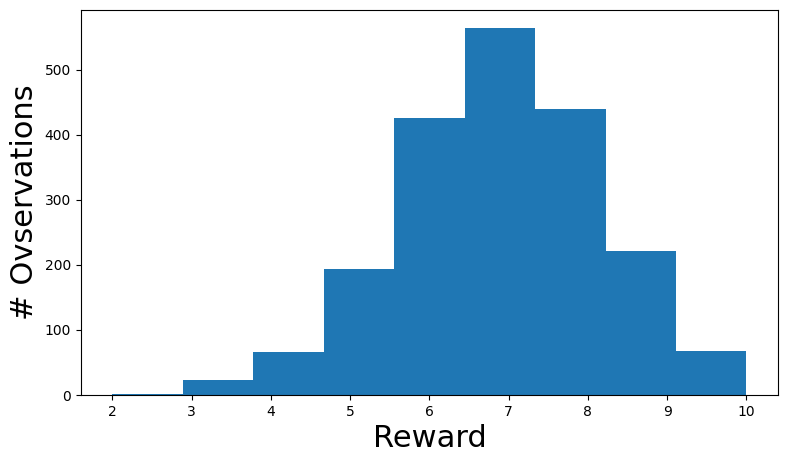

In [8]:
plt.figure(figsize=(9,5))
plt.xlabel("Reward",fontsize=22)
plt.ylabel("# Ovservations",fontsize=22)
plt.hist(reward_test,bins=9)

In [9]:
record = np.zeros((n,2))

In [10]:
# 计算最佳动作
def get_best_arm(record):
    arm_index = np.argmax(record[:,1],axis=0)
    return arm_index

In [11]:
# 更新记录
def update_record(record,action,r):
    new_r = (record[action,0] * record[action,1] + r) / (record[action,0] + 1)
    record[action,0] += 1
    record[action,1] = new_r
    return record

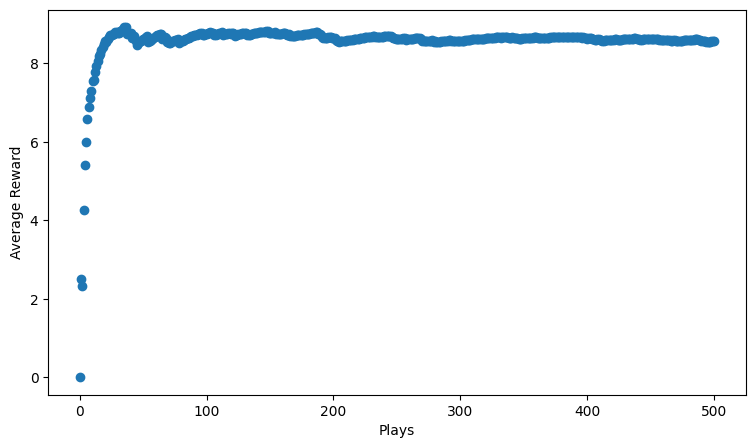

In [12]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Average Reward")
fig.set_size_inches(9,5)
rewards = [0]

# 计算每个臂对应于其当前动作-价值softmax概率
for i in range(500):
    if random.random() > eps:
        choice = get_best_arm(record)
    else:
        choice = np.random.randint(10)

    # 计算选择臂的奖励
    r = get_reward(probs[choice])

    # 利用新数量和臂的奖励观察值更新数组record
    record = update_record(record,choice,r)

    # 跟踪运行的平均奖励评估整体表现
    mean_reward = ((i+1) * rewards[-1] + r) / (i+2)
    rewards.append(mean_reward)

ax.scatter(np.arange(len(rewards)),rewards)

In [13]:
def softmax(av, tau=1.12):
    softm = (np.exp(av / tau) / np.sum(np.exp(av / tau)))
    return softm

In [14]:
probs = np.random.rand(n)
record = np.zeros((n,2))

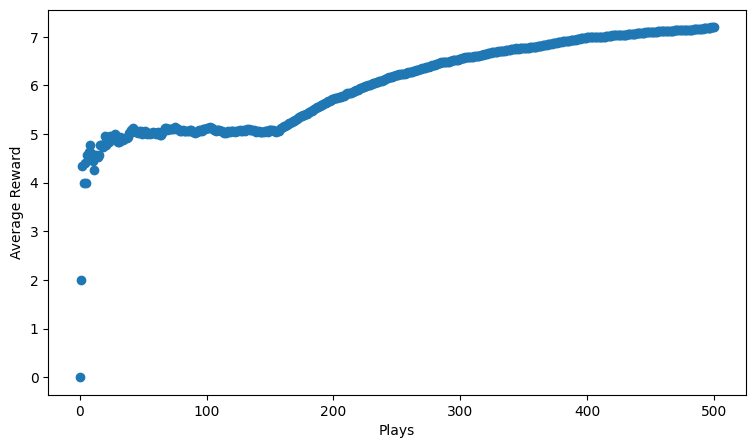

In [15]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Average Reward")
fig.set_size_inches(9,5)
rewards = [0]

for i in range(500):
    p = softmax(record[:,1],tau=0.7)
    choice = np.random.choice(np.arange(n),p=p)
    r = get_reward(probs[choice])
    record = update_record(record,choice,r)
    mean_reward = ((i+1) * rewards[-1] + r) / (i+2)
    rewards.append(mean_reward)

ax.scatter(np.arange(len(rewards)),rewards)

In [16]:
# 上下文赌博机
class ContextBandit:
    def __init__(self,arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()

    #
    def init_distribution(self,arms):
        self.bandit_matrix = np.random.rand(arms,arms)

    def reward(self,prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward

    # 返回一个从均匀分布中随机抽样的状态
    def get_state(self):
        return self.state

    def update_state(self):
        self.state = np.random.randint(0,self.arms)

    def get_reward(self,arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])

    def choose_arm(self,arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward

In [17]:
import numpy as np
import torch

In [18]:
arms = 10
N, D_in, H, D_out = 1, arms, 100, arms

In [19]:
env = ContextBandit(arms=10)
state = env.get_state()
reward = env.choose_arm(1)
print(state)

0


In [20]:
# 双层前馈神经网络
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(), # 激活函数
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU(),
)

In [21]:
# 均方误差损失函数
loss_fn = torch.nn.MSELoss()

In [22]:
env = ContextBandit(arms)

In [23]:
def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

In [24]:
def running_mean(x, N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv) / N
    return y

In [25]:
# 训练
def train(env, epoches=5000, learning_rate=1e-2):
    cur_state = torch.Tensor(one_hot(arms,env.get_state()))
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    rewards = []

    for i in range(epoches):
        y_pred = model(cur_state)

        # 将奖励预测转换为概率分布
        av_softmax = softmax(y_pred.data.numpy(), tau=0.2)

        # 进行正态化 确保和为1
        av_softmax /= av_softmax.sum()

        # 随机选择新的动作
        choice = np.random.choice(arms,p=av_softmax)
        cur_reward = env.choose_arm(choice)  # 返回该动作生成的奖励

        one_hot_reward = y_pred.data.numpy().copy()

        # 更新one_hot_reward数组 用作标记的训练数据
        one_hot_reward[choice] = cur_reward
        reward = torch.Tensor(one_hot_reward)
        rewards.append(cur_reward)
        loss = loss_fn(y_pred, reward)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 更新当前环境状态
        cur_state = torch.Tensor(one_hot(arms,env.get_state()))

    return np.array(rewards)

In [26]:
rewards = train(env)

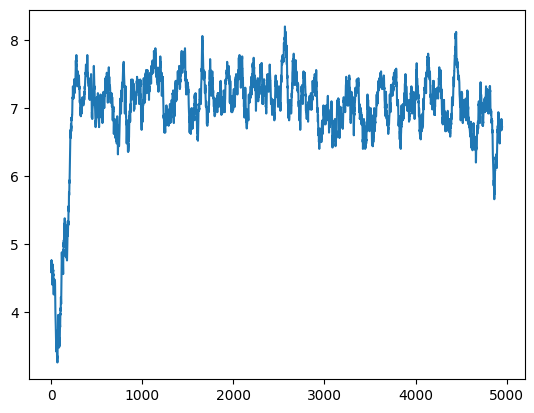

In [27]:
plt.plot(running_mean(rewards,N=50))